In [1]:
import numpy as np 
import pandas as pd 
import xarray as xr 
from matplotlib import pyplot as plt 
import glob
import dask.array as da
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
from matplotlib import colors, cm
from matplotlib.colors import Normalize
import scipy.io as sio
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


class MidpointNormalize(Normalize):
    """Normalise the colorbar.  e.g. norm=MidpointNormalize(mymin, mymax, 0.)"""
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
    
    #get viridis colormaps
def cmap_codes(name, number):
    cmap = cm.get_cmap(name, number) 
    hexcodes = []
    for i in range(cmap.N): 
        hexcodes.append(colors.rgb2hex(cmap(i)[:3]))
    return hexcodes

cmap_codes('viridis', 4)

['#440154', '#31688e', '#35b779', '#fde725']

# load ICE6G & GLAC-1D

In [2]:
#Load ice reconstructions
path = '/Users/rogercreel/ws/Holocene_readv/ice_grids/'
ice6g = sio.loadmat(path + 'ice6g_data.mat', struct_as_record=False)
ice = ice6g['ice6g']
ice_lat = ice6g['ice_lat']
ice_long = ice6g['ice_long']
ice_time = ice6g['ice_time']

ds_6g = xr.Dataset({'rsl':(['age', 'lat', 'long'], ice)},
                   coords={'age': (['age'], ice_time[0,:]),
                       'lat': (['lat'], ice_lat[:,0]),
                          'long':(['long'], ice_long[:,0])}).rename({'long':'lon'})
ds_6g['age'] = ds_6g.age * 1000

ds_glac1d = xr.open_mfdataset(glob.glob(path + 'glac1d_/TOP*'), combine='by_coords')
ds_glac1d = ds_glac1d.rename({'XLONGLOB1':'lon', 'YLATGLOBP5':'lat', 'T122KP11':'age'})
ds_glac1d['rsl'] = ds_glac1d.ICEM * ds_glac1d.HDC
ds_glac1d['age'] = ds_glac1d['age'] * -1000

# Compare deglacial ice thicknesses

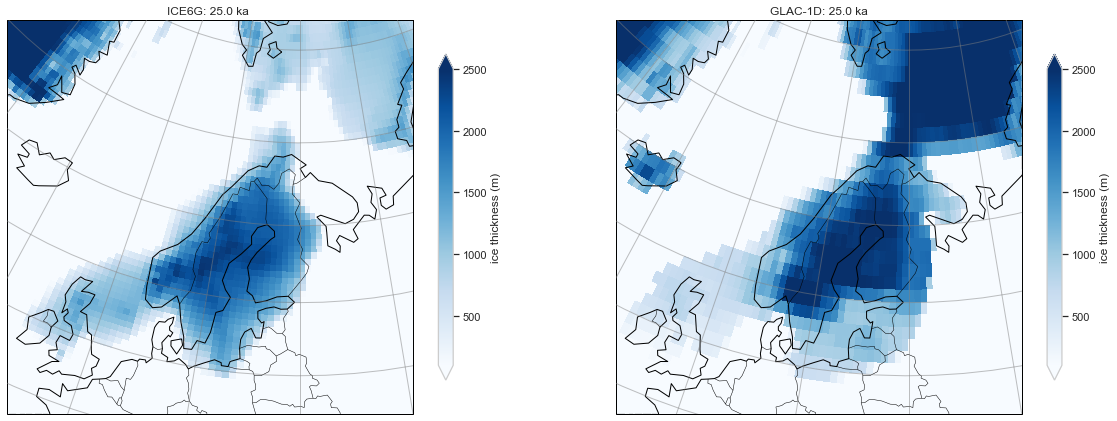

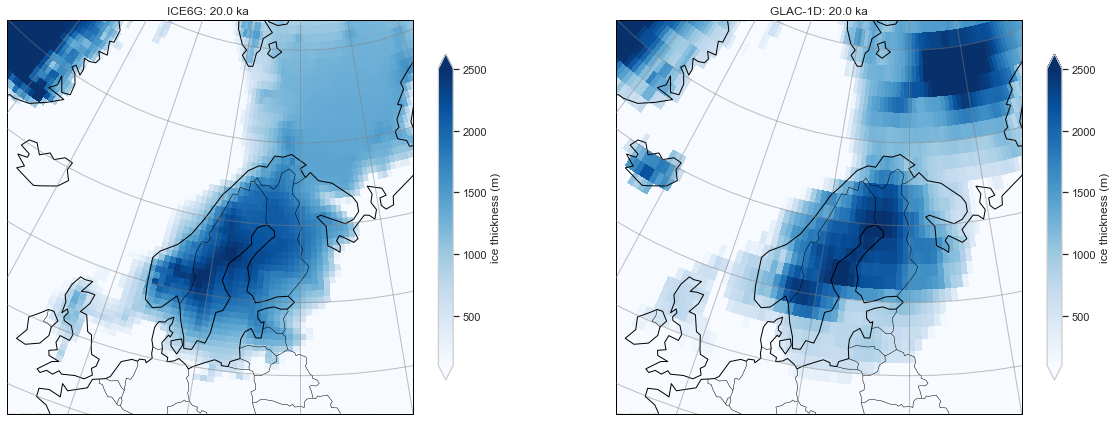

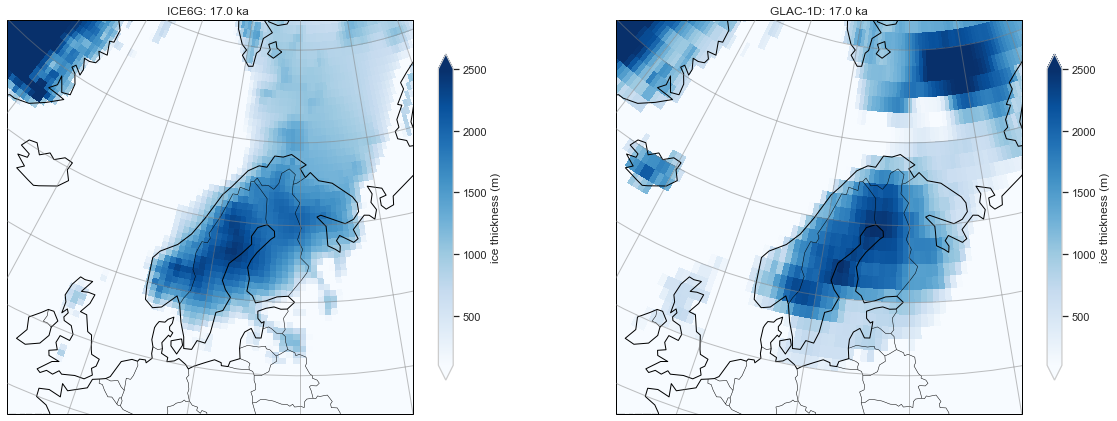

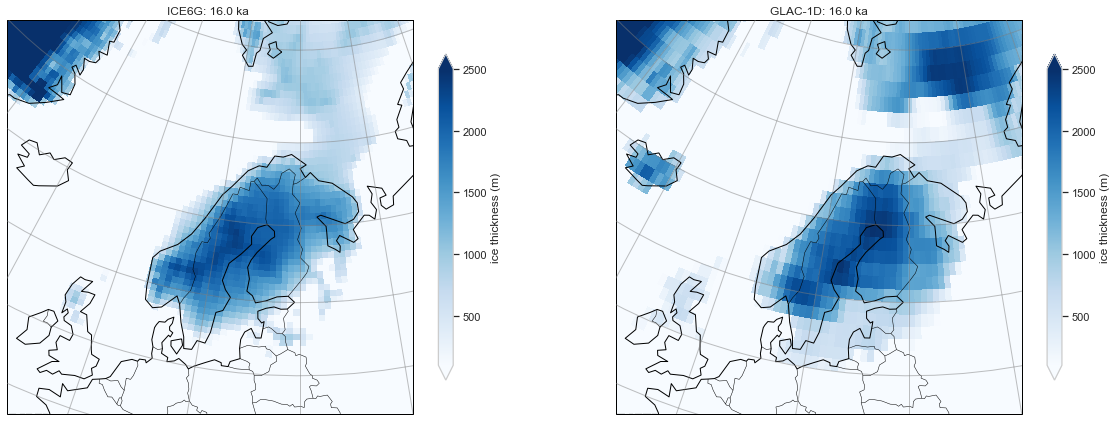

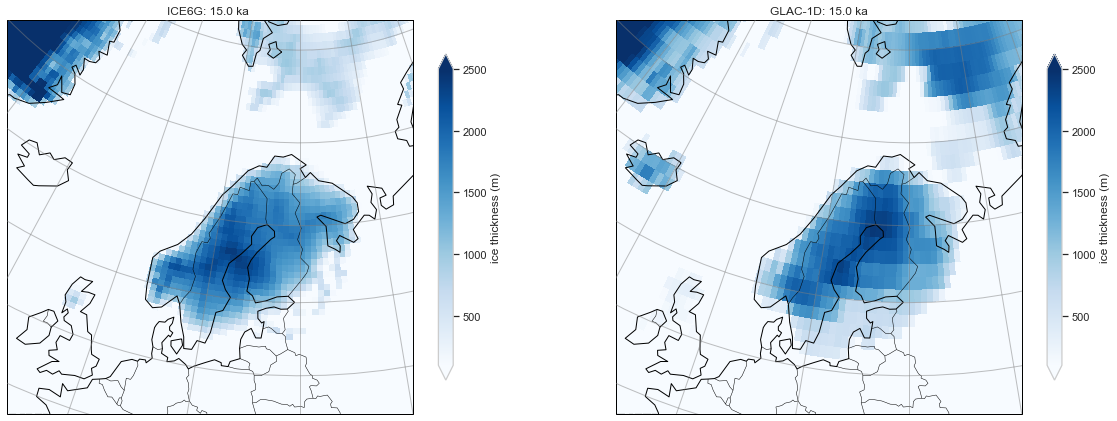

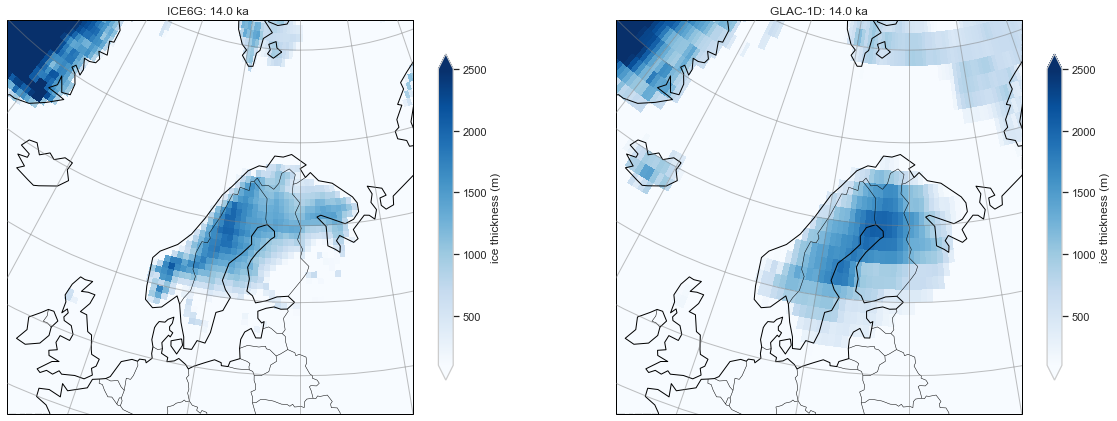

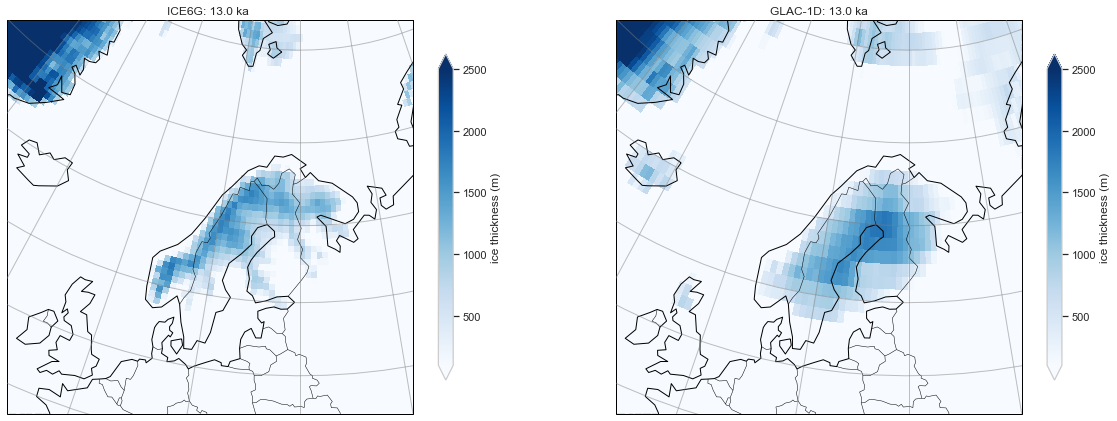

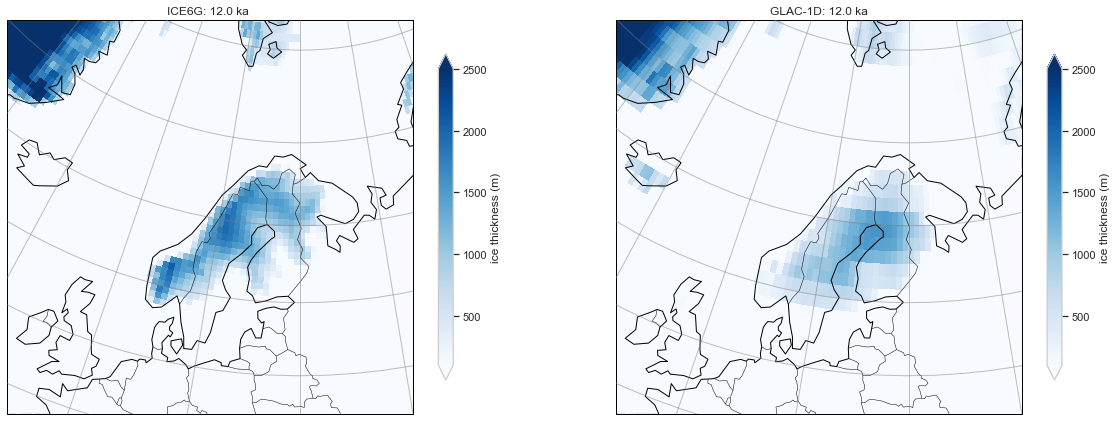

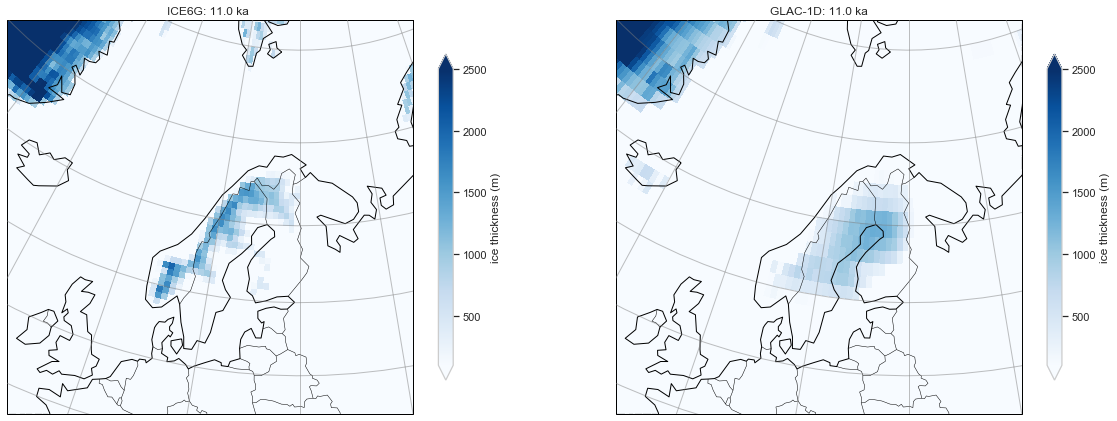

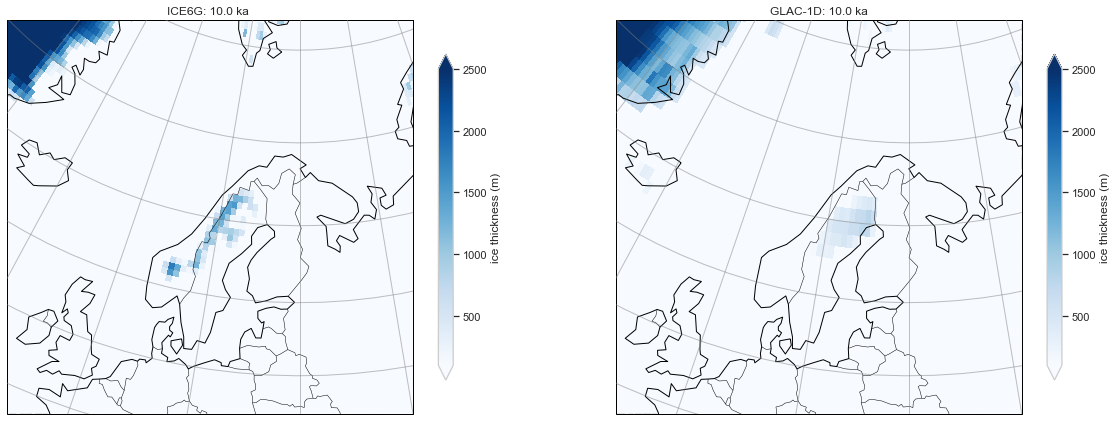

In [26]:
place = 'fennoscandia'
ice_model = 'd6g_h6g_' # 'glac1d_'
# plot ice reconstructions through deglaciation 
locs = {'england': [-12, 2, 50, 60],
        'easternhem': [50, 178, -45, 80],
        'westernhem': [-175, 30, -80, 75],
        'world': [-179.8, 179.8, -89.8, 89.8],
        'namerica': [-150, -20, 10, 75],
        'eastcoast': [-88, -65, 15, 40],
        'europe': [-20, 15, 35, 70],
        'atlantic':[-85,47, 25, 73],
        'fennoscandia': [-10, 45, 50, 78]}

extent = locs[place]

def make_ax(num):
    
    ax[num].set_extent(extent)
    ax[num].coastlines(resolution='110m', linewidth=1, zorder=2)
    ax[num].add_feature(cfeature.OCEAN, color='gray', zorder=0)
    # ax[0].add_feature(cfeature.LAND, color='palegreen', zorder=1)
    ax[num].add_feature(cfeature.BORDERS, linewidth=0.5, zorder=3)
    ax[num].gridlines(linewidth=1, color='gray', alpha=0.5, zorder=4)
    
times = [25000, 20000, 17000, 16000, 15000, 14000, 13000, 12000, 11000, 10000]
cmap = 'Blues'
vmin=100
vmax=2500

for i, age in enumerate(times):
    
    proj=  ccrs.LambertConformal(central_longitude=30) 
    trans =ccrs.PlateCarree()
    fig, ax = plt.subplots(1, 2, figsize=(20, 15), sharey=True,
                           subplot_kw=dict(projection=proj))
    ax = ax.flatten()
    
    make_ax(0)
    pc1 = ds_glac1d.rsl.sel(age=age).plot(ax=ax[0], transform=trans, vmin=vmin, vmax=vmax,
                                     cmap=cmap, add_colorbar=False, extend='both', zorder=2)
    cbar = fig.colorbar(pc1,ax=ax[0],shrink=.4,label='ice thickness (m)', extend='both')
    ax[0].set_title(f'ICE6G: {age/1000} ka ')

    make_ax(1)
    pc2 = ds_6g.rsl.sel(age=age).plot(ax=ax[1], transform=trans, vmin=vmin, vmax=vmax,
                                     cmap=cmap, add_colorbar=False, extend='both', zorder=2)
    cbar = fig.colorbar(pc2,ax=ax[1],shrink=.4,label='ice thickness (m)', extend='both')
    ax[1].set_title(f'GLAC-1D: {age/1000} ka')

# Load HOLSEA and new Fennoscandian RSL data

In [27]:
#load RSL data

tmax = '12010'
tmin = '5490'

tmax, tmin, tstep = int(tmax), int(tmin), 100

ages_lgm = np.arange(100, 26000, tstep)[::-1]

#import khan dataset
path = 'data/GSL_LGM_120519_.csv'

df = pd.read_csv(path, encoding="ISO-8859-15", engine='python')
df = df.replace('\s+', '_', regex=True).replace('-', '_', regex=True).\
        applymap(lambda s:s.lower() if type(s) == str else s)
df.columns = df.columns.str.lower()
df.rename_axis('index', inplace=True)
df = df.rename({'latitude': 'lat', 'longitude': 'lon'}, axis='columns')
dfind, dfterr, dfmar = df[(df.type == 0)
                          & (df.age > 0)], df[df.type == 1], df[df.type == -1]
np.sort(list(set(dfind.regionname1)))

#select location
df_pl = dfind[(dfind.age > tmin) & (dfind.age < tmax) &
                 (dfind.lon > extent[0])
                 & (dfind.lon < extent[1])
                 & (dfind.lat > extent[2])
                 & (dfind.lat < extent[3])]

# [['lat', 'lon', 'rsl', 'rsl_er_max', 'age']]
df_place = df_pl[['lat', 'lon', 'rsl', 'rsl_er_max', 'age']]

#Import new Fennoscandia database
path = '/Users/rogercreel/ws/Holocene_readv/data/holocene_fennoscandian_data.csv'
df_newlocs = pd.read_csv(path, header=2)[2:].rename({'Latitude':'lat', 'Longitude':'lon', 'Column heading': 'col_head'}, axis='columns')
df_newlocs['lon'] = df_newlocs.lon.astype(float)
df_newlocs['lat'] = df_newlocs.lat.astype(float)

# Map data locations 

In [5]:
def group_dfs(df):
    df_cts = df.groupby(['lat', 'lon']).count().reset_index()[['lat', 'lon', 'age']]
    df_dur = df.groupby(['lat', 'lon']).max()['age'] # - df.groupby(['lat', 'lon']).min()['age']
    return df_cts, df_dur

sed = df_pl[df_pl.primary_indicator == 'sedimentary_indicator']
sed = pd.concat([sed, df_pl[df_pl.type_category == 'sedimentary_indicator']])
basin = df_pl[df_pl.primary_indicator == 'isolation_basin']
basin = pd.concat([basin, df_pl[df_pl.type_category == 'isolation_basin'] ])
beach = df_pl[df_pl.primary_indicator == 'raised/storm_beach']
beach = pd.concat([beach, df_pl[df_pl.type_category == 'raised_beach']])
terrace = df_pl[df_pl.primary_indicator == 'marine_terrace']
terrace = pd.concat([terrace, df_pl[df_pl.type_category == 'marine_terrace']])

basin_ct, basin_dur = group_dfs(basin)
terrace_ct, terrace_dur = group_dfs(terrace)
sed_ct, sed_dur = group_dfs(sed)
beach_ct, beach_dur = group_dfs(beach)


dfcounts_place = df_place.groupby(['lat', 'lon']).count().reset_index()[['lat', 'lon', 'rsl', 'age']]
dfcounts_place_new = df_newlocs.groupby(['lat', 'lon']).count().reset_index()[['lat', 'lon', 'col_head']]

# plot locations of data and potential new data
proj=  ccrs.LambertConformal(central_longitude=30) 
trans =ccrs.PlateCarree()

fig, ax = plt.subplots(1, 1, figsize=(20, 15), subplot_kw=dict(projection=proj))

ax.set_extent(extent)
ax.coastlines(resolution='110m', linewidth=1, zorder=2)
ax.add_feature(cfeature.OCEAN, color='lightgray', zorder=0)
ax.add_feature(cfeature.LAND, color='white', zorder=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=3)
ax.gridlines(linewidth=1, color='white', alpha=0.5, zorder=4)

# plot old locations
# ax.scatter(dfcounts_place.lon, dfcounts_place.lat,
#                   s=dfcounts_place.age * 50, c='lightsalmon',
#                   edgecolor='k',linewidths=1,transform=ccrs.PlateCarree(), zorder=5)

scat4 = ax.scatter(basin_ct.lon, basin_ct.lat, s=basin_ct.age * 50, c=basin_dur, cmap='viridis_r', edgecolor='k', linewidths=1,
                   transform=ccrs.PlateCarree(), zorder=6, marker='s')

ax.scatter(terrace_ct.lon, terrace_ct.lat,s=terrace_ct.age * 50, c=terrace_dur, cmap='viridis_r', edgecolor='k', linewidths=1,
                   transform=ccrs.PlateCarree(), zorder=5, marker='P')

scat2 = ax.scatter(beach_ct.lon, beach_ct.lat, s=beach_ct.age * 50, c=beach_dur, cmap='viridis_r', edgecolor='k', linewidths=1,
                   transform=ccrs.PlateCarree(), zorder=5, marker='*')

scat = ax.scatter(sed_ct.lon, sed_ct.lat, s=sed_ct.age * 50, c=sed_dur, cmap='viridis_r', edgecolor='k', linewidths=1,
                   transform=ccrs.PlateCarree(), zorder=5, marker='o')

#plot new locations
scat1 = ax.scatter(dfcounts_place_new.lon, dfcounts_place_new.lat, s=dfcounts_place_new.col_head * 50, c='red',
                  edgecolor='k', linewidths=1,transform=ccrs.PlateCarree(), zorder=5, marker='s')



size1 = Line2D(range(4), range(4), color="black", marker='o', linewidth=0,
              linestyle='none',markersize=14, markerfacecolor="white")
size2 = Line2D(range(4), range(4), color="black", marker='s', linewidth=0,
              linestyle='none',markersize=14, markerfacecolor="white")

size3 = Line2D(range(4), range(4), color="black", linewidth=0, linestyle='none', markersize=14,marker='P', markerfacecolor="white")

size4 = Line2D(range(4), range(4), color="black", linewidth=0, linestyle='none', markersize=14, marker='*', markerfacecolor="white")

size5 = Line2D(range(4), range(4), color="black", linewidth=0, linestyle='none', markersize=14,marker='s', markerfacecolor="red")
size6 = Line2D(range(4), range(4), color="white", linewidth=0, linestyle='none', markerfacecolor="white")
size7 = Line2D(range(4), range(4), color="white", linewidth=0, linestyle='none', markerfacecolor="white")
size8 = Line2D(range(8), range(8), color="white", linewidth=0, linestyle='none', markerfacecolor="white")

labels = ['Sedimentary indicator', 'Isolation basin', 'Marine terrace', 'Raised beach', 'New isolation basin database  ', '', '', '']
leg = plt.legend([size1, size2, size3, size4, size5, size6, size7, size8], labels, loc='lower left', bbox_to_anchor=(0.60, 0.00),
                 prop={'size': 20}, fancybox=True)
leg.get_frame().set_edgecolor('k')
ax.set_title('')
cbaxes = inset_axes(ax, width="30%", height="3%", loc=4, borderpad=6) 
cbar = fig.colorbar(scat4, ax=ax, cax=cbaxes, shrink=.7, 
                    label='Minimum age of indicator point (yrs) \n currently in HOLSEA database', 
                   orientation='horizontal')

AssertionError: 

# Fiddle plots of likelihoods

Distribution of likelihoods for Ice6g and Glac-1d, 71 & 96 km lith & suite of um/lm viscosities 


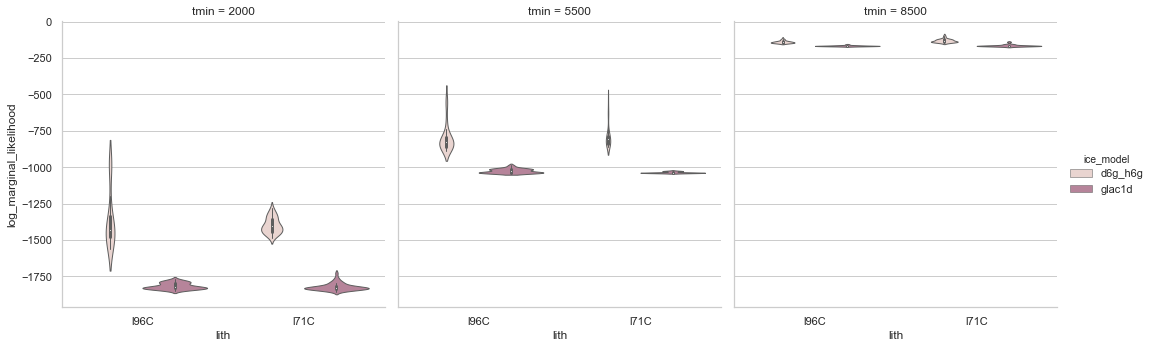

In [28]:
def make_likedf(model, tmin):
    allfiles = glob.glob(f'/Users/rogercreel/Desktop/cluster_output_26202/12000*{tmin}*{model}*fennoscandia*likelihood')
#     allfiles = glob.glob(f'/Users/rogercreel/Desktop/12000*{tmin}*{model}*fennoscandia*likelihood')

    
    df = pd.concat((pd.read_csv(f, index_col=None) for f in allfiles)) 

    df['ice_model'] = [key.split('_l')[0] for key in df.modelrun]
    df['lith'] = [key.split('_')[-3:][0] for key in df.modelrun]
    df['um'] = [key.split('_')[-3:][1][-1] for key in df.modelrun]
    df['lm'] = [key.split('_')[-3:][2][2:] for key in df.modelrun]
    df['tmin'] = tmin
    df.lm = df.lm.astype(float)
    df.um = df.um.astype(float)
    return df

tmins = [8500, 5500, 2000] #[10000, 5000, 2000]
model = ['d6g_h6g', 'glac1d']

df_likes = []
for i, tmin in enumerate(tmins):
    df_it_glac = make_likedf(model[0], tmin)
    df_it_6g = make_likedf(model[1], tmin)
    df_comb = pd.concat([df_it_glac,df_it_6g])
    
    df_likes.append(df_comb)
    
df_out = pd.concat(df_likes)
df_out

sns.set(style="whitegrid")
pal = sns.cubehelix_palette(3, dark=0.3)
sns.catplot(x='lith', y="log_marginal_likelihood", hue='ice_model', data=df_out, kind='violin', # hue='um', 
            bw=0.5, cut=1.5, linewidth=1, palette=pal, # inner='points',
           col='tmin');
# ax.text(x=0.5, y=1.1, s='Sepal Length vs Width', fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)


print('Distribution of likelihoods for Ice6g and Glac-1d, 71 & 96 km lith & suite of um/lm viscosities ');

# sns.set(style="whitegrid")
# pal = sns.cubehelix_palette(11, rot=-.4, dark=0.6)
# sns.catplot(x='lith', y="log_marginal_likelihood", hue='ice_model', data=df_out, kind='violin', # hue='um', 
#             bw=0.5, cut=1.5, linewidth=1, palette=pal, # inner='points',
#            col='tmin');

# sns.set(style="whitegrid")
# pal = sns.cubehelix_palette(11, rot=-.4, dark=0.3)
# sns.catplot(x='lith', y="log_marginal_likelihood", hue='ice_model', data=df_out, kind='violin', # hue='um', 
#             bw=0.5, cut=1.5, linewidth=1, palette=pal, # inner='points',
#            col='tmin');

# Heat maps of GPR likelihoods

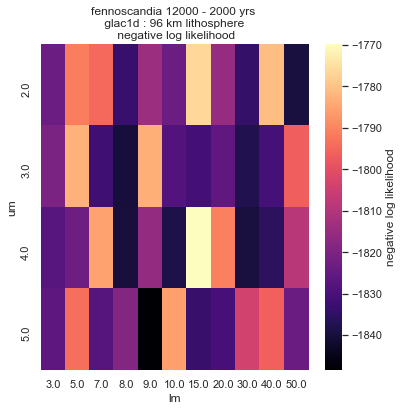

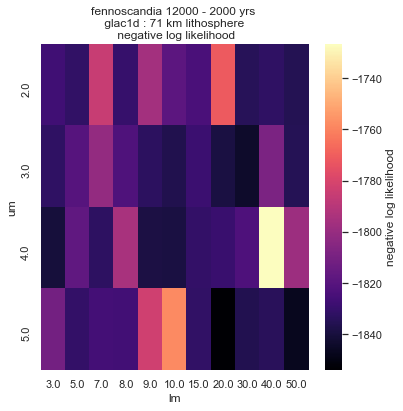

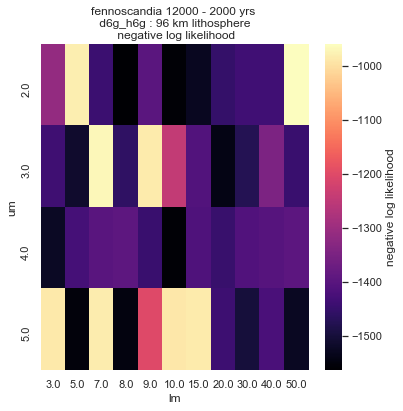

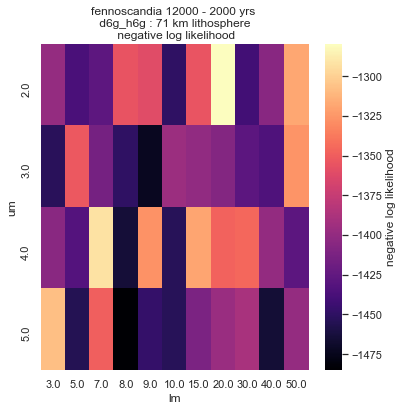

In [980]:
#plot only for a single tmin:
tmin = 2000
df_outstep = df_out[df_out.tmin == tmin]

# df.log_marginal_likelihood = - df.log_marginal_likelihood
df_glac = df_outstep[df_outstep.ice_model == 'glac1d']
df_glac1d_l96C = df_glac[df_glac.lith == 'l96C']
df_glac1d_l71C = df_glac[df_glac.lith == 'l71C']

df_6g = df_outstep[df_outstep.ice_model == 'd6g_h6g']
df_d6g_h6g_l96C = df_6g[df_6g.lith == 'l96C']
df_d6g_h6g_l71C = df_6g[df_6g.lith == 'l71C']

def make_heatmap(df, model, lith, vmin=None, vmax=None):
    heatmap = df.pivot_table(index='um', columns='lm', values='log_marginal_likelihood')

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    sns.heatmap(heatmap,  cmap='magma', ax=ax,  cbar_kws={'label': 'negative log likelihood'})
    ax.set_title('label')

    ax.set_title(f'{place} {tmax} - {tmin} yrs \n {model} : {lith} km lithosphere \n negative log likelihood')
    plt.show()
    
lith = ['l71C', 'l96C']

make_heatmap(df_glac1d_l96C, 'glac1d', '96')
make_heatmap(df_glac1d_l71C, 'glac1d', '71')

# heatmap = df_d6g_h6g_l71C.pivot_table(index='um', columns='lm', values='log_marginal_likelihood')

# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# sns.heatmap(heatmap,  cmap='magma', ax=ax,  cbar_kws={'label': 'negative log likelihood'},
#            vmin=-1500, vmax=-1450)
# ax.set_title('label')

# ax.set_title(f'{place} {tmax} - {tmin} yrs \n ice6g : 96 km lithosphere')
# plt.show()

make_heatmap(df_d6g_h6g_l96C, 'd6g_h6g', '96')

make_heatmap(df_d6g_h6g_l71C, 'd6g_h6g', '71')

# fig.savefig(dirName + f'{path_gen}_likelihood_heatmap', transparent=True)


# RMSE of GPR residual vs. RSL data for all models

Question: is it better to use MAE or RMSE?  If being off by 10 is only twice as bad as being off by 5, then MAE.  But if 10 vs. 5 is more than twice as bad, then RMSE.

In [887]:
# tmax=12010
# tmin=1990

# path = 'data/GSL_LGM_120519_.csv'

# df = pd.read_csv(path, encoding="ISO-8859-15", engine='python')
# df = df.replace('\s+', '_', regex=True).replace('-', '_', regex=True).\
#         applymap(lambda s:s.lower() if type(s) == str else s)
# df.columns = df.columns.str.lower()
# df.rename_axis('index', inplace=True)
# df = df.rename({'latitude': 'lat', 'longitude': 'lon'}, axis='columns')
# dfind, dfterr, dfmar = df[(df.type == 0)
#                           & (df.age > 0)], df[df.type == 1], df[df.type == -1]
# np.sort(list(set(dfind.regionname1)))

# #select location
# df_place = dfind[(dfind.age > tmin) &
#                  (dfind.age < tmax) & 
#                 (dfind.lon > extent[0]) 
#                  & (dfind.lon < extent[1])
#                  & (dfind.lat > extent[2])
#                  & (dfind.lat < extent[3])][['lat', 'lon', 'rsl','rsl_er_max', 'age']]
# df_place.shape

In [888]:
# names = ['giaprior', 'gpvariance', 'dazp', 'posterior']

# globvar = glob.glob(f'/Users/rogercreel/Desktop/cluster_output_26201/12000*{tmin}*fennoscandia*{names[0]}')
# globvar
# ds = xr.open_mfdataset(globvar, concat_dim='model', combine='nested')
# model = ["_".join("_".join(val.split('_')[2:]).split('_')[:-2])[17:] for val in globvar]
# ds['model'] = model
# ds = ds.drop('scale')
# ds.rsl.sel(model='glac1d_l71C_ump2_lm3')[:,:,1].plot()

In [1375]:
# #download GPR model outputs

# # Fix this to be prettier

# # ice_model = 'glac1d_'

# varname = 'giaprior'
# globvar = glob.glob(f'/Users/rogercreel/Desktop/cluster_output_2620/12000*10000*{ice_model}*fennoscandia*{varname}')
# model = ["_".join("_".join(val.split('_')[2:]).split('_')[:-2])[17:] for val in globvar]
# ds_giaprior_glac = xr.open_mfdataset(globvar, concat_dim='model', combine='nested')
# ds_giaprior_glac['model'] = model

# varname = 'gpvariance'
# globvar = glob.glob(f'/Users/rogercreel/Desktop/cluster_output_2620/12000*10000*{ice_model}*fennoscandia*{varname}')
# model = ["_".join("_".join(val.split('_')[2:]).split('_')[:-2])[17:] for val in globvar]
# ds_var_glac = xr.open_mfdataset(globvar, concat_dim='model', combine='nested')
# ds_var_glac = ds_var_glac.rename({'__xarray_dataarray_variable__':'rsl'})
# ds_var_glac['model'] = model

# varname = 'posterior'
# globvar = glob.glob(f'/Users/rogercreel/Desktop/cluster_output_2620/12000*10000*{ice_model}*fennoscandia*{varname}')
# model = ["_".join("_".join(val.split('_')[2:]).split('_')[:-2])[17:] for val in globvar]
# ds_post_glac = xr.open_mfdataset(globvar, concat_dim='model', combine='nested')
# ds_post_glac = ds_post_glac.rename({'__xarray_dataarray_variable__':'rsl'})
# ds_post_glac['model'] = model

# varname = 'dazp'
# globvar = glob.glob(f'/Users/rogercreel/Desktop/cluster_output_2620/12000*10000*{ice_model}*fennoscandia*{varname}')
# model = ["_".join("_".join(val.split('_')[2:]).split('_')[:-2])[17:] for val in globvar]
# ds_zp_glac = xr.open_mfdataset(globvar, concat_dim='model', combine='nested')
# ds_zp_glac = ds_zp_glac.rename({'__xarray_dataarray_variable__':'rsl'})
# ds_zp_glac['model'] = model

# ice_model = 'd6g_h6g_'

# varname = 'giaprior'
# globvar = glob.glob(f'/Users/rogercreel/Desktop/cluster_output_2620/12000*10000*{ice_model}*fennoscandia*{varname}')
# model = ["_".join("_".join(val.split('_')[2:]).split('_')[:-2])[17:] for val in globvar]
# ds_giaprior_6g = xr.open_mfdataset(globvar, concat_dim='model', combine='nested')
# ds_giaprior_6g['model'] = model

# varname = 'gpvariance'
# globvar = glob.glob(f'/Users/rogercreel/Desktop/cluster_output_2620/12000*10000*{ice_model}*fennoscandia*{varname}')
# model = ["_".join("_".join(val.split('_')[2:]).split('_')[:-2])[17:] for val in globvar]
# ds_var_6g = xr.open_mfdataset(globvar, concat_dim='model', combine='nested')
# ds_var_6g = ds_var_6g.rename({'__xarray_dataarray_variable__':'rsl'})
# ds_var_6g['model'] = model
# # ds_var_6g = ds_var_6g.drop('modelrun')

# varname = 'posterior'
# globvar = glob.glob(f'/Users/rogercreel/Desktop/cluster_output_2620/12000*10000*{ice_model}*fennoscandia*{varname}')
# model = ["_".join("_".join(val.split('_')[2:]).split('_')[:-2])[17:] for val in globvar]
# ds_post_6g = xr.open_mfdataset(globvar, concat_dim='model', combine='nested')
# ds_post_6g = ds_post_6g.rename({'__xarray_dataarray_variable__':'rsl'})
# ds_post_6g['model'] = model
# ds_post_6g = ds_post_6g.drop('modelrun')

# varname = 'dazp'
# globvar = glob.glob(f'/Users/rogercreel/Desktop/cluster_output_2620/12000*10000*{ice_model}*fennoscandia*{varname}')
# model = ["_".join("_".join(val.split('_')[2:]).split('_')[:-2])[17:] for val in globvar]
# ds_zp_6g = xr.open_mfdataset(globvar, concat_dim='model', combine='nested')
# ds_zp_6g = ds_zp_6g.rename({'__xarray_dataarray_variable__':'rsl'})
# ds_zp_6g['model'] = model

# ds_zp_6g



# # ds_giaprior_glac
# # ds.rsl.sel(model='glac1d_l71C_ump2_lm3')[:,:,1].plot(vmin=0, vmax=60, cmap='coolwarm')

In [17]:
globvar

['/Users/rogercreel/Desktop/12000_2000_glac1d_l96C_ump4_lm3_fennoscandia_giaprior',
 '/Users/rogercreel/Desktop/12000_2000_glac1d_l96C_ump2_lm3_fennoscandia_giaprior',
 '/Users/rogercreel/Desktop/12000_2000_glac1d_l96C_ump5_lm3_fennoscandia_giaprior']

In [18]:
varname = 'giaprior'
globvar = glob.glob(f'/Users/rogercreel/Desktop/12000*{vmin}*{ice_model}*fennoscandia*{varname}')
model = ["_".join("_".join(val.split('_')[2:]).split('_')[:-2]) for val in globvar]
model

['glac1d_l96C_ump4_lm3', 'glac1d_l96C_ump2_lm3', 'glac1d_l96C_ump5_lm3']

In [30]:
#choose vmin
# ice_model = 'glac1d_'
vmin=2000

def download_files(vmin, ice_model, varname):
    
#     globvar = glob.glob(f'/Users/rogercreel/Desktop/cluster_output_2520/12000*2000*{ice_model}*fennoscandia*{varname}')
#     globvar = glob.glob(f'/Users/rogercreel/Desktop/cluster_output_26201/12000*{vmin}*{ice_model}*fennoscandia*{varname}')
    globvar = glob.glob(f'/Users/rogercreel/Desktop/12000*{vmin}*{ice_model}*fennoscandia*{varname}')

    model = ["_".join("_".join(val.split('_')[2:]).split('_')[:-2]) for val in globvar] #[17:]
    ds = xr.open_mfdataset(globvar, concat_dim='model', combine='nested')
    ds['model'] = model
    try:
        ds = ds.rename({'__xarray_dataarray_variable__':'rsl'})
    except:
        pass
    
    try:
        ds = ds.drop('scale')
    except:
        pass
    try:
        ds = ds.drop('modelrun')
    except:
        pass
 
    return ds
names = ['giaprior', 'gpvariance', 'dazp', 'posterior']

if ice_model == 'glac1d_':
    ds_giaprior_glac, ds_var_glac, ds_zp_glac, ds_post_glac  = [download_files(vmin, 'glac1d_', it) for it in names]

elif ice_model == 'd6g_h6g_':
    ds_giaprior_6g, ds_var_6g, ds_zp_6g, ds_post_6g  = [download_files(vmin, 'd6g_h6g_', it) for it in names]
    
ds_giaprior_6g

<xarray.Dataset>
Dimensions:  (age: 101, lat: 50, lon: 50, model: 11)
Coordinates:
  * lat      (lat) float64 43.86 44.42 44.98 45.54 ... 69.55 70.11 70.67 71.23
  * age      (age) int64 12000 11900 11800 11700 11600 ... 2300 2200 2100 2000
  * lon      (lon) float64 -11.95 -10.74 -9.539 -8.334 ... 43.49 44.7 45.9 47.11
  * model    (model) <U22 'd6g_h6g_l96C_ump5_lm9' ... 'd6g_h6g_l96C_ump5_lm10'
Data variables:
    rsl      (model, lat, lon, age) float64 dask.array<chunksize=(1, 50, 50, 101), meta=np.ndarray>

In [ ]:
#### TO DO: run with prior as well as posterior to demonstrate improvement of model over data ####

def calc(ds_zp, ds_giaprior, loc):
    ds_zp_out = ds_zp.interp(lat=loc.lat, lon=loc.lon, age=loc.age, method='nearest')
    ds_giaprior_out = ds_giaprior.interp(lat=loc.lat, lon=loc.lon, age=loc.age, method='nearest')
    ds_err = (ds_zp_out - loc.rsl - ds_giaprior_out)**2

    return ds_err
out = []
for i, loc in df_place.iterrows():
    if ice_model == 'glac1d_':
        ds_err = calc(ds_zp_glac, ds_giaprior_glac, loc)
        out.append(ds_err.to_dataframe())
        print(i)
    elif ice_model == 'd6g_h6g_':
        ds_err = calc(ds_zp_6g, ds_giaprior_6g, loc)
        out.append(ds_err.to_dataframe())
        print(i)
    
all_resids = pd.concat(out).reset_index()
##***** This needs to be better automated to accept either ice model ** 

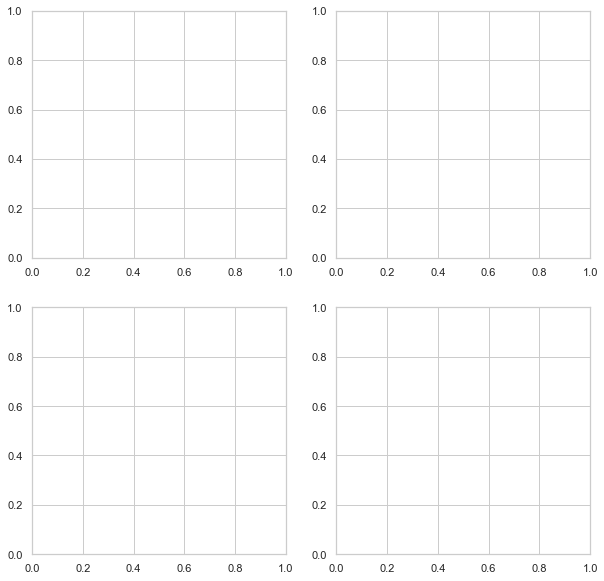

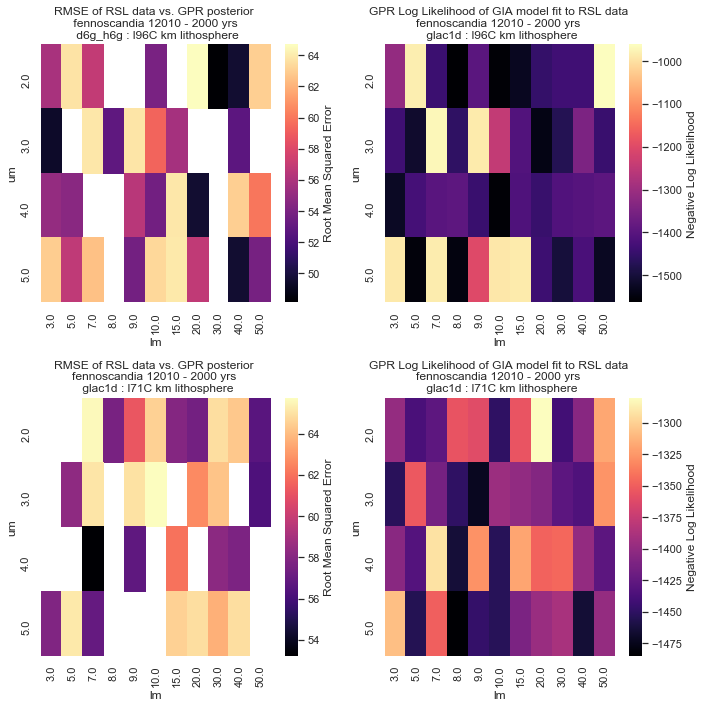

In [1131]:
df_re = pd.DataFrame(np.sqrt(all_resids.groupby('model')['rsl'].mean())).reset_index().rename(columns={'rsl':'rmse'})
df_re['ice_model'] = [key.split('_l')[0] for key in df_re.model]
df_re['lith'] = [key.split('_')[-3:][0] for key in df_re.model]
df_re['um'] = [key.split('_')[-3:][1][-1] for key in df_re.model]
df_re['lm'] = [key.split('_')[-3:][2][2:] for key in df_re.model]

df_re.lm = df_re.lm.astype(float)
df_re.um = df_re.um.astype(float)

df_reglac = df_re[df_re.ice_model == 'glac1d']
df_reglac1d_l96C = df_reglac[df_reglac.lith == 'l96C']
df_reglac1d_l71C = df_reglac[df_reglac.lith == 'l71C']

df_re6g = df_re[df_re.ice_model == 'd6g_h6g']
df_red6g_h6g_l96C = df_re6g[df_re6g.lith == 'l96C']
df_red6g_h6g_l71C = df_re6g[df_re6g.lith == 'l71C']
    
model = ['glac1d', 'd6g_h6g', ]
lith = ['l96C', 'l71C']

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.flatten()

if len(df_reglac) > 0:
    
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax = ax.flatten()

    heatmap = df_reglac1d_l96C.pivot_table(index='um', columns='lm', values='rmse')
    sns.heatmap(heatmap, cmap='magma', ax=ax[0],  cbar_kws={'label': 'Root Mean Squared Error'})
    ax[0].set_title('label')
    ax[0].set_title(f'RMSE of RSL data vs. GPR posterior \n {place} {tmax} - {tmin} yrs \n {model[0]} : {lith[0]} km lithosphere')

    heatmap2 = df_glac1d_l96C.pivot_table(index='um', columns='lm', values='log_marginal_likelihood')
    sns.heatmap(heatmap2, cmap='magma', ax=ax[1],  cbar_kws={'label': 'Negative Log Likelihood'})
    ax[1].set_title('label')
    ax[1].set_title(f'GPR Log Likelihood of GIA model fit to RSL data \n' +
                    f'{place} {tmax} - {tmin} yrs \n {model[0]} : {lith[0]} km lithosphere')

    heatmap3 = df_reglac1d_l71C.pivot_table(index='um', columns='lm', values='rmse')
    sns.heatmap(heatmap3, cmap='magma', ax=ax[2],  cbar_kws={'label': 'Root Mean Squared Error'})
    ax[2].set_title('label')
    ax[2].set_title(f'RMSE of RSL data vs. GPR posterior \n' + 
                    f'{place} {tmax} - {tmin} yrs \n {model[0]} : {lith[1]} km lithosphere')

    heatmap4 = df_glac1d_l71C.pivot_table(index='um', columns='lm', values='log_marginal_likelihood')
    sns.heatmap(heatmap4, cmap='magma', ax=ax[3],  cbar_kws={'label': 'Negative Log Likelihood'})
    ax[3].set_title('label')
    ax[3].set_title(f'GPR Log Likelihood of GIA model fit to RSL data \n' + 
                    f'{place} {tmax} - {tmin} yrs \n {model[0]} : {lith[1]} km lithosphere')
    plt.tight_layout()
    plt.show()
    
if len(df_re6g) > 0:
    
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax = ax.flatten()

    heatmap = df_red6g_h6g_l96C.pivot_table(index='um', columns='lm', values='rmse')
    sns.heatmap(heatmap, cmap='magma', ax=ax[0],  cbar_kws={'label': 'Root Mean Squared Error'})
    ax[0].set_title('label')
    ax[0].set_title(f'RMSE of RSL data vs. GPR posterior \n {place} {tmax} - {tmin} yrs \n {model[1]} : {lith[0]} km lithosphere')

    heatmap2 = df_d6g_h6g_l96C.pivot_table(index='um', columns='lm', values='log_marginal_likelihood')
    sns.heatmap(heatmap2, cmap='magma', ax=ax[1],  cbar_kws={'label': 'Negative Log Likelihood'})
    ax[1].set_title('label')
    ax[1].set_title(f'GPR Log Likelihood of GIA model fit to RSL data \n' +
                    f'{place} {tmax} - {tmin} yrs \n {model[0]} : {lith[0]} km lithosphere')

    heatmap3 = df_red6g_h6g_l71C.pivot_table(index='um', columns='lm', values='rmse')
    sns.heatmap(heatmap3, cmap='magma', ax=ax[2],  cbar_kws={'label': 'Root Mean Squared Error'})
    ax[2].set_title('label')
    ax[2].set_title(f'RMSE of RSL data vs. GPR posterior \n' + 
                    f'{place} {tmax} - {tmin} yrs \n {model[0]} : {lith[1]} km lithosphere')

    heatmap4 = df_d6g_h6g_l71C.pivot_table(index='um', columns='lm', values='log_marginal_likelihood')
    sns.heatmap(heatmap4, cmap='magma', ax=ax[3],  cbar_kws={'label': 'Negative Log Likelihood'})
    ax[3].set_title('label')
    ax[3].set_title(f'GPR Log Likelihood of GIA model fit to RSL data \n' + 
                    f'{place} {tmax} - {tmin} yrs \n {model[0]} : {lith[1]} km lithosphere')
    
    plt.tight_layout()
    plt.show()


# Plot RSL as mean of model outputs weighted by likelihoods

In [31]:
def make_likedf(model, tmin):
#     allfiles = glob.glob(f'/Users/rogercreel/Desktop/cluster_output_26202/12000*{tmin}*{model}*fennoscandia*likelihood')
    allfiles = glob.glob(f'/Users/rogercreel/Desktop/12000*{tmin}*{model}*fennoscandia*likelihood')

    
    df = pd.concat((pd.read_csv(f, index_col=None) for f in allfiles)) 

    df['ice_model'] = [key.split('_l')[0] for key in df.modelrun]
    df['lith'] = [key.split('_')[-3:][0] for key in df.modelrun]
    df['um'] = [key.split('_')[-3:][1][-1] for key in df.modelrun]
    df['lm'] = [key.split('_')[-3:][2][2:] for key in df.modelrun]
    df['tmin'] = tmin
    df.lm = df.lm.astype(float)
    df.um = df.um.astype(float)
    return df

/anaconda3/envs/gpflow6_0/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/anaconda3/envs/gpflow6_0/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/anaconda3/envs/gpflow6_0/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/anaconda3/envs/gpflow6_0/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/anaconda3/envs/gpflow6_0/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/anaconda3/envs/gpflow6_0/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x

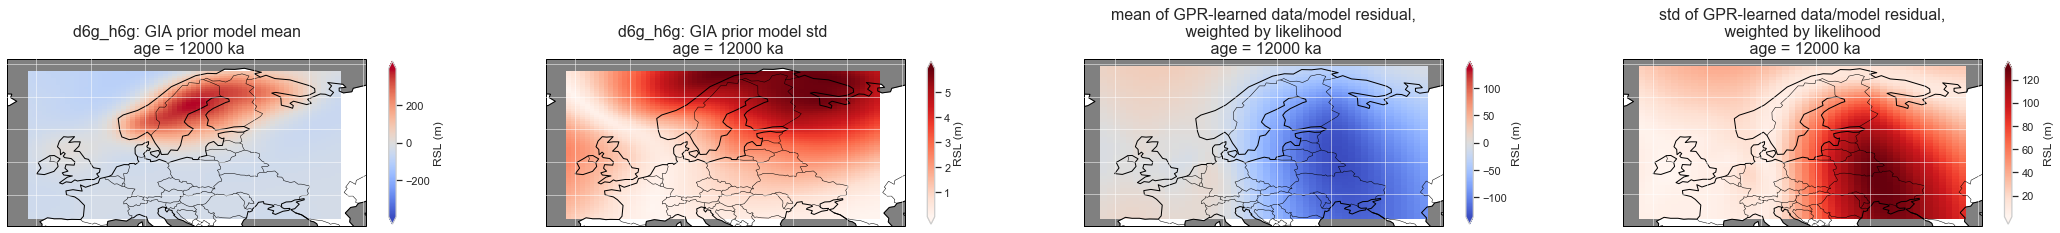

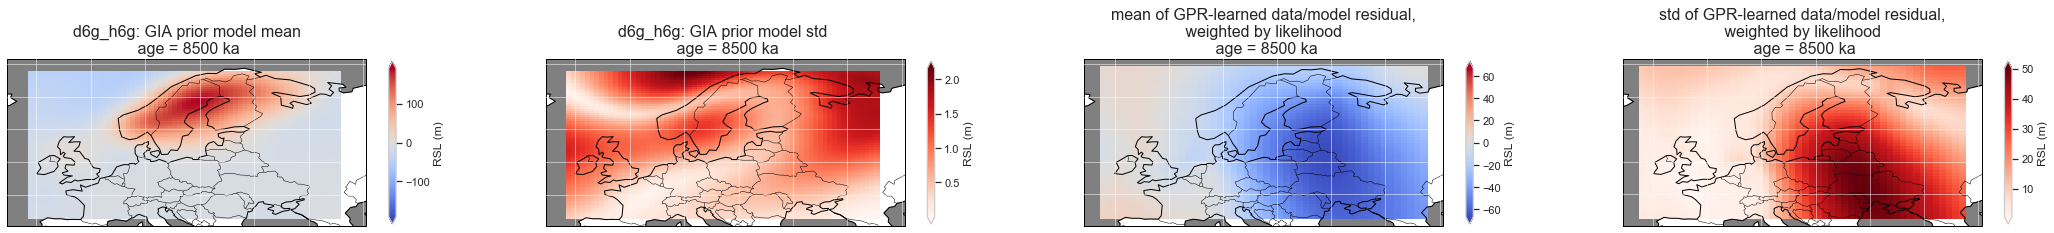

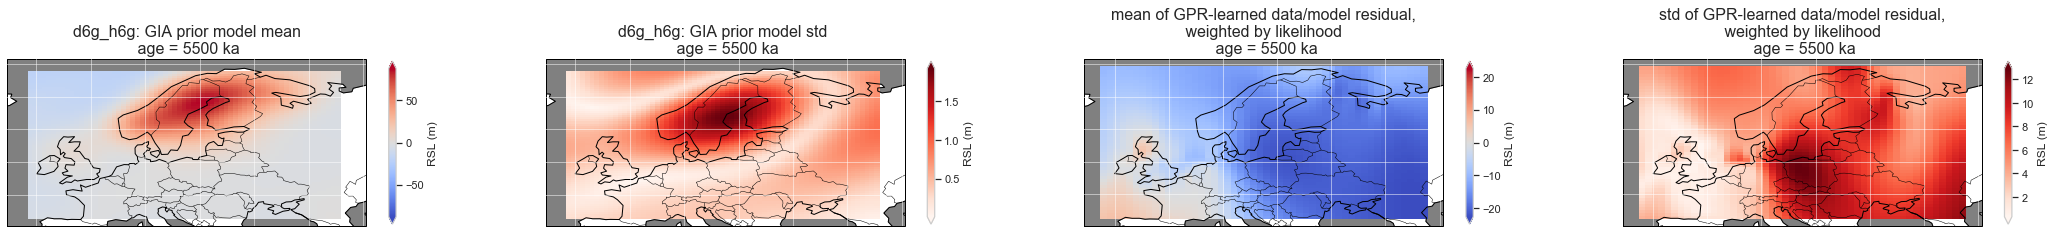

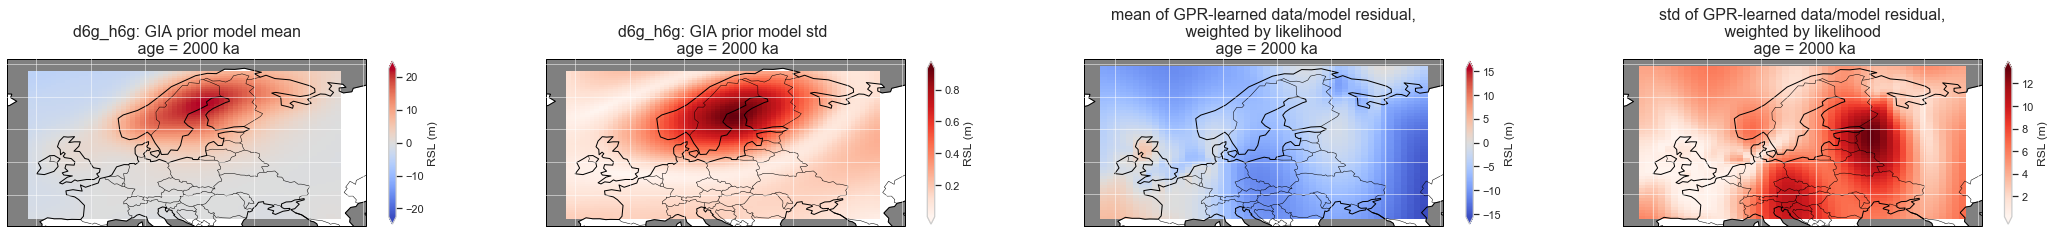

In [33]:
ice_model = 'd6g_h6g_'
tmin=2000

# choose models to run
df_likes = make_likedf(ice_model, tmin)

# normalize likelihoods, make neg log likelihood into positive
df_likes['rsl'] = -1 * df_likes.log_marginal_likelihood / df_likes.log_marginal_likelihood.sum()
df_likes['rsl'] = df_likes.rsl / df_likes.rsl.mean()

#rename rsl so it can broadcast to other datasets
df_weights = df_likes.rename(columns={'modelrun':'model'})[['model', 'rsl']].set_index('model').to_xarray()

if ice_model == 'd6g_h6g_':
# RSL weighted by likelihood
    ds_weightedposterior = (ds_zp_6g * df_weights)   ####### either 6g or glac1dd
    ds_weightedrsl = ds_weightedposterior + ds_giaprior_6g
    ds_weightdiff = (ds_weightedrsl.mean(dim='model') - ds_post_6g.mean(dim='model'))
    
    #RSL variance weighted by likelihood
    ds_weightedrsl_var = (ds_var_6g * df_weights)
    
elif ice_model == 'glac1d_':
    ds_weightedposterior = (ds_zp_glac * df_weights)   ####### either 6g or glac1dd
    ds_weightedrsl = ds_weightedposterior + ds_giaprior_glac
    ds_weightdiff = (ds_weightedrsl.mean(dim='model') - ds_post_glac.mean(dim='model'))

    #RSL variance weighted by likelihood
    ds_weightedrsl_var = (ds_var_glac * df_weights)

# Full variance: weighted variance of GPR posterior + weighted variance of model means
ds_weightedrsl_total = xr.ufuncs.square(ds_weightedrsl.rsl.std(dim='model')) + ds_weightedrsl_var.rsl.mean(dim='model')

proj = ccrs.PlateCarree()

ages = [12000, 8500, 5500, 2000]
cbar_kwargs = {'shrink': 0.3,'label':'RSL (m)'}
vmin=-100
vmax=100
vmin_var = -0.1
vmax_var = 10
fontsize=16

def make_ax(num):
    ax[num].coastlines(resolution='110m', linewidth=1, zorder=2)
    ax[num].add_feature(cfeature.OCEAN, color='gray', zorder=0)
    ax[num].add_feature(cfeature.BORDERS, linewidth=0.5, zorder=3)
    ax[num].gridlines(linewidth=1, color='white', alpha=0.5, zorder=4)

for i, age in enumerate(ages):
    
    fig, ax = plt.subplots(1, 4, figsize=(37, 10), subplot_kw=dict(projection=proj))
    ax=ax.flatten()
    
    make_ax(0)
    ds_giaprior_glac.rsl.mean(dim='model').sel(age=age).plot(ax=ax[0], cmap='coolwarm', #norm=MidpointNormalize(vmin, vmax, 0),
                                                          cbar_kwargs=cbar_kwargs, extend='both')
    ax[0].set_title(f'{ice_model[:-1]}: GIA prior model mean\n age = {age} ka', fontsize=fontsize)
    
    make_ax(1)
    ds_giaprior_glac.rsl.std(dim='model').sel(age=age).plot(ax=ax[1],cmap='Reds', cbar_kwargs=cbar_kwargs, extend='both',
                                                         )
    ax[1].set_title(f'{ice_model[:-1]}: GIA prior model std \n age = {age} ka', fontsize=fontsize)
    
       
    make_ax(2)
    ds_weightedposterior.rsl.mean(dim='model').sel(age=age).plot(ax=ax[2],cmap='coolwarm', cbar_kwargs=cbar_kwargs, extend='both',
                                                         )
    ax[2].set_title(f'mean of GPR-learned data/model residual,\n weighted by likelihood \n age = {age} ka', fontsize=fontsize)
    
    make_ax(3)
    ds_weightedposterior.rsl.std(dim='model').sel(age=age).plot(ax=ax[3],cmap='Reds', cbar_kwargs=cbar_kwargs, extend='both',
                                                         )
    ax[3].set_title(f'std of GPR-learned data/model residual,\n weighted by likelihood \n age = {age} ka', fontsize=fontsize)

/anaconda3/envs/gpflow6_0/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/anaconda3/envs/gpflow6_0/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/anaconda3/envs/gpflow6_0/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/anaconda3/envs/gpflow6_0/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/anaconda3/envs/gpflow6_0/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/anaconda3/envs/gpflow6_0/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x

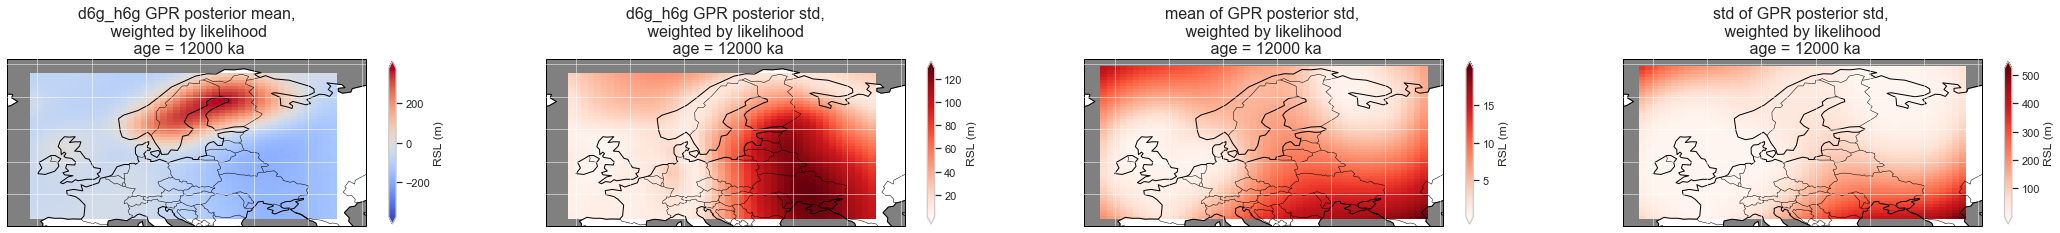

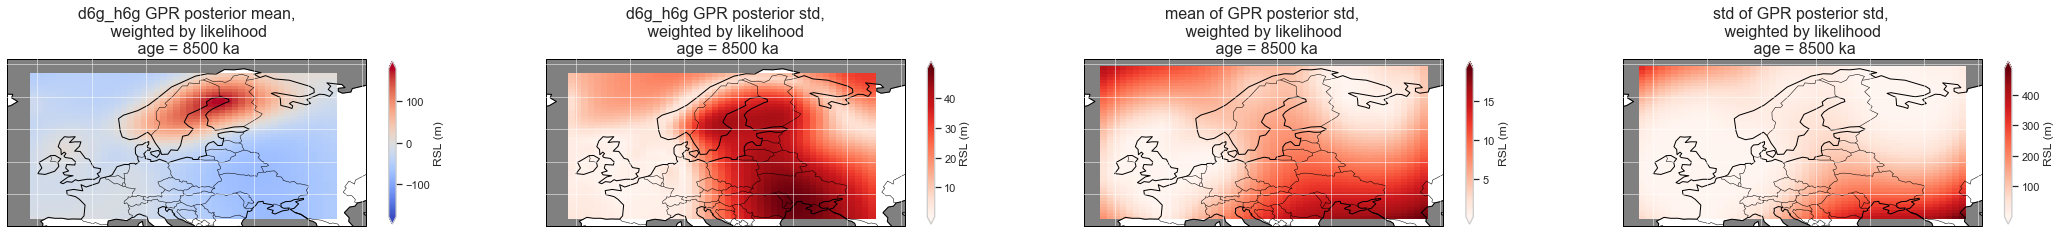

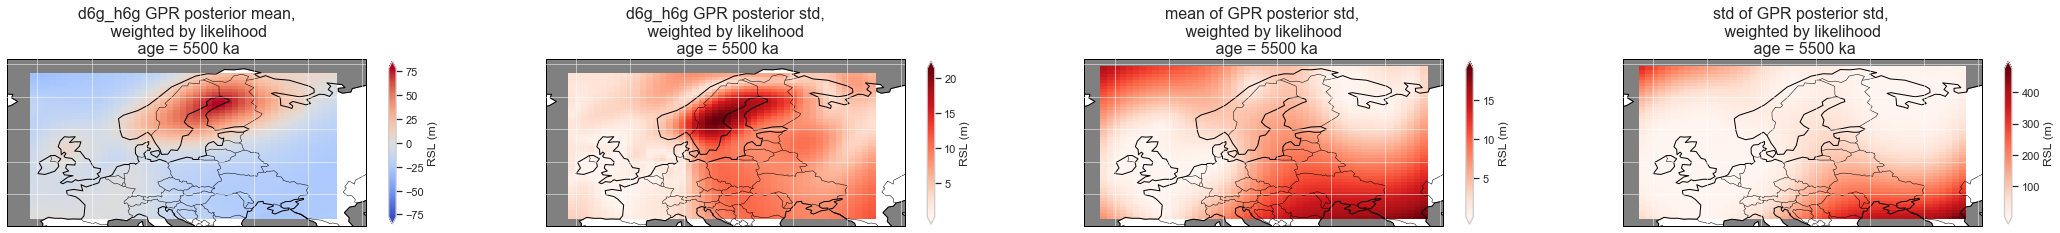

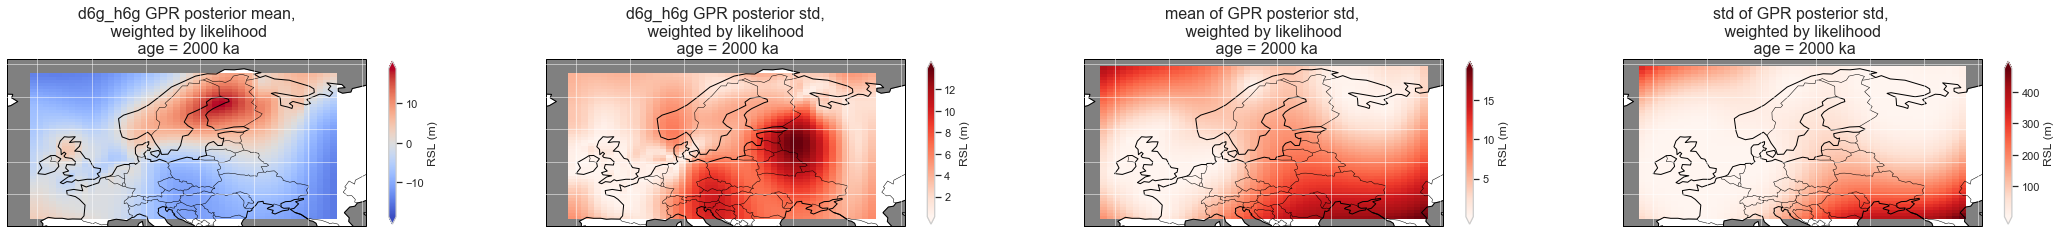

In [34]:
# Plot posterior with 

for i, age in enumerate(ages):
    
    fig, ax = plt.subplots(1, 4, figsize=(37, 10), subplot_kw=dict(projection=proj))
    ax=ax.flatten()
    
    make_ax(0)
    ds_weightedrsl.rsl.mean(dim='model').sel(age=age).plot(ax=ax[0], cmap='coolwarm', # norm=MidpointNormalize(vmin, vmax, 0),
                                                          cbar_kwargs=cbar_kwargs, extend='both')
    ax[0].set_title(f'{ice_model[:-1]} GPR posterior mean,\n weighted by likelihood\n age = {age} ka', fontsize=fontsize)

    make_ax(1)
    ds_weightedrsl.rsl.std(dim='model').sel(age=age).plot(ax=ax[1],cmap='Reds', cbar_kwargs=cbar_kwargs, extend='both',
                                                         )
    ax[1].set_title(f'{ice_model[:-1]} GPR posterior std,\n weighted by likelihood \n age = {age} ka', fontsize=fontsize) 
    
    make_ax(2)
    xr.ufuncs.sqrt(ds_weightedrsl_var.rsl.mean(dim='model')).sel(age=age).plot(ax=ax[2],cmap='Reds', cbar_kwargs=cbar_kwargs, extend='both')
    ax[2].set_title(f'mean of GPR posterior std, \n weighted by likelihood \n age = {age} ka', fontsize=fontsize) 
    
    make_ax(3)
    ds_weightedrsl_var.rsl.std(dim='model').sel(age=age).plot(ax=ax[3],cmap='Reds', cbar_kwargs=cbar_kwargs, extend='both')
    ax[3].set_title(f'std of GPR posterior std, \n weighted by likelihood \n age = {age} ka', fontsize=fontsize) 

# 1D plots: Alternative: compare priors to posteriors for models with equal likelihoods but drastically different model parameters (e.g. upper mantle viscosity)? 

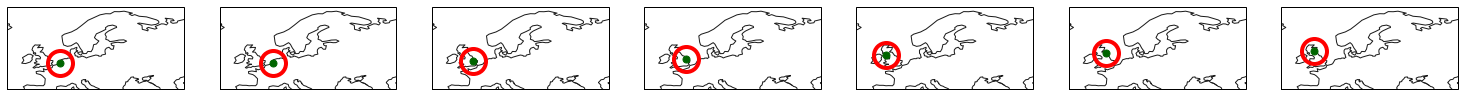

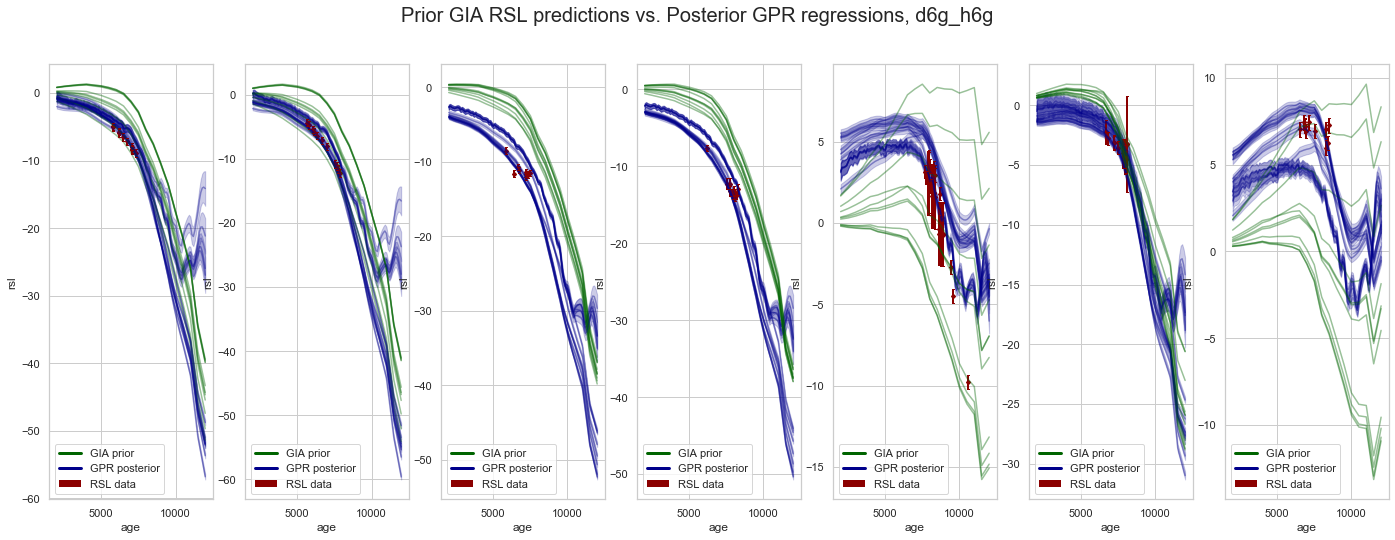

In [35]:
#normalize likelihoods to between zero and one
df_likes['weight'] = -1 * df_likes.log_marginal_likelihood 
df_likes['weight'] = (df_likes.weight - df_likes.weight.min())/(df_likes.weight.max() - df_likes.weight.min()) 

#Choose subset of models with largest likelihoods
n = 60
df_biglikes = df_likes.nsmallest(n, columns='log_marginal_likelihood')


if ice_model == 'glac1d_':
    ds_postbig = ds_weightedrsl.sel(model=df_biglikes.modelrun.values)

    ds_priorbig = ds_giaprior_glac.sel(model=df_biglikes.modelrun.values)
    ds_varbig = ds_var_glac.sel(model=df_biglikes.modelrun.values)
    
elif ice_model == 'd6g_h6g_':
    #since not all models run
    ds_postbig = ds_weightedrsl
    ds_priorbig = ds_giaprior_6g
    ds_varbig = ds_var_6g
#     ds_priorbig = ds_giaprior_6g.sel(model=df_biglikes.modelrun.values)
#     ds_varbig = ds_var_6g.sel(model=df_biglikes.modelrun.values)
    
    

def locs_with_enoughsamples(df_place, place, number):
    """make new dataframe, labeled, of sites with [> number] measurements"""
    df_lots = df_place.groupby(['lat',
                                'lon']).filter(lambda x: len(x) > number)

    df_locs = []
    for i, group in enumerate(df_lots.groupby(['lat', 'lon'])):
        singleloc = group[1].copy()
        singleloc['location'] = place
        singleloc['locnum'] = place + '_site' + str(
            i)  # + singleloc.reset_index().index.astype('str')
        df_locs.append(singleloc)
    df_locs = pd.concat(df_locs)

    return df_locs

if tmin == 2000:
    number = 8
elif tmin == 6000:
    number = 5
elif tmin == 9000:
    number = 2

df_nufsamps = locs_with_enoughsamples(df_place, place, number)
nufsamp = df_nufsamps.locnum.unique()

def slice_dataarray(da):
    return da.sel(lat=site[1].lat.unique(),
                  lon=site[1].lon.unique(),
                  method='nearest')

colormark = ['darkgreen', 'darkblue', 'darkred', 'violet']
cmaps = cmap_codes('viridis', len(df_biglikes))

###### Plot Locations #####
proj = ccrs.PlateCarree()

fig, ax = plt.subplots(1,len(nufsamp), figsize=(26, 6), subplot_kw=dict(projection=proj))
ax = ax.ravel()

da_zeros = xr.zeros_like(ds_zp_glac.rsl[0,:,:,:])

for i, site in enumerate(df_nufsamps.groupby('locnum')):
    ax[i].coastlines(color='k')
    ax[i].plot(site[1].lon.unique(),
               site[1].lat.unique(),
               c=colormark[0],
               ms=7,
               marker='o',
               transform=proj)
    ax[i].plot(site[1].lon.unique(),
               site[1].lat.unique(),
               c=colormark[0],
               ms=25,
               marker='o',
               transform=proj,
               mfc="None",
               mec='red',
               mew=4)
    da_zeros[0].plot(ax=ax[i], cmap='Greys', add_colorbar=False)
#     ax[i].set_title(site[0], fontsize=fontsize)
    ax[i].set_title('')


##### Plot Data-Model fit ######

    
fig, ax = plt.subplots(1, len(nufsamp), figsize=(24, 8))
ax = ax.ravel()

fontsize = 18
lw = 1.5
    
for i, site in enumerate(df_nufsamps.groupby('locnum')):
    
    
#     for j, mod in enumerate(df_biglikes.modelrun):
    for j, mod in enumerate(ds_priorbig.rsl.model):
        
        plt.suptitle(f"Prior GIA RSL predictions vs. Posterior GPR regressions, {ice_model[:-1]}", fontsize=20)
        
#         weight = df_biglikes[df_biglikes.modelrun == mod].weight[0]

        da_giaprior = ds_priorbig.rsl.sel(model=mod)
        da_postbig = ds_postbig.rsl.sel(model=mod)
        da_varbig = ds_varbig.rsl.sel(model=mod)
        
        if ice_model == 'glac1d_':
            da_giaprior = ds_priorbig.rsl.sel(model=mod)
            da_postbig = ds_postbig.rsl.sel(model=mod)
            da_varbig = ds_varbig.rsl.sel(model=mod)
        

        elif ice_model == 'd6g_h6g_':
        #since not all models run
            ds_postbig = ds_weightedrsl
            ds_priorbig = ds_giaprior_6g
            ds_varbig = ds_var_6g
#     ds_priorbig = ds_giaprior_6g.sel(model=df_biglikes.modelrun.values)
#     ds_varbig = ds_var_6g.sel(model=df_biglikes.modelrun.values)
    

        #slice data for each site
        prior_it = slice_dataarray(da_giaprior)

        post_it = slice_dataarray(da_postbig)
        var_it = slice_dataarray(np.sqrt(da_varbig))
        top = post_it + var_it * 2
        bottom = post_it - var_it * 2

        site_err = 2 * (site[1].rsl_er_max)

        prior_it.plot(ax=ax[i], c=colormark[0], alpha=0.4, label='GIA prior')# label='Prior $\pm 2 \sigma$') c=cmaps[j]

        post_it.plot(ax=ax[i], lw=lw, c=colormark[1], alpha=0.4, label='GPR posterior')# label='Posterior $\pm 2 \sigma$') c=cmaps[j],
        ax[i].fill_between(post_it.age, bottom.squeeze(), top.squeeze(), color=colormark[1], alpha=0.2) #  color=cmaps[j],
        ax[i].scatter(site[1].age, site[1].rsl, c=colormark[2], s=4, lw=lw,label='RSL data')
        ax[i].errorbar(site[1].age, site[1].rsl,site_err, c=colormark[2], fmt='none',
                       capsize=1,lw=1.5)

        ax[i].set_title('')

    from matplotlib.lines import Line2D
    from matplotlib.patches import Circle

    lines = [Line2D([0], [0], color=colormark[0], linewidth=3, linestyle='-'), 
             Line2D([0], [0], color=colormark[1], linewidth=3, linestyle='-'),
             Circle([0], 0.1, color=colormark[2], linewidth=3, ec="none")]

    labels = ['GIA prior', 'GPR posterior', 'RSL data']
    ax[i].legend(lines, labels, loc='lower left')


    #         fig.savefig(dirName + f'{path_gen}_1Dfig',
    #                     transparent=True)
plt.show()

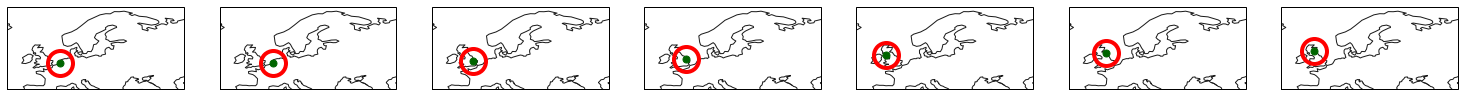

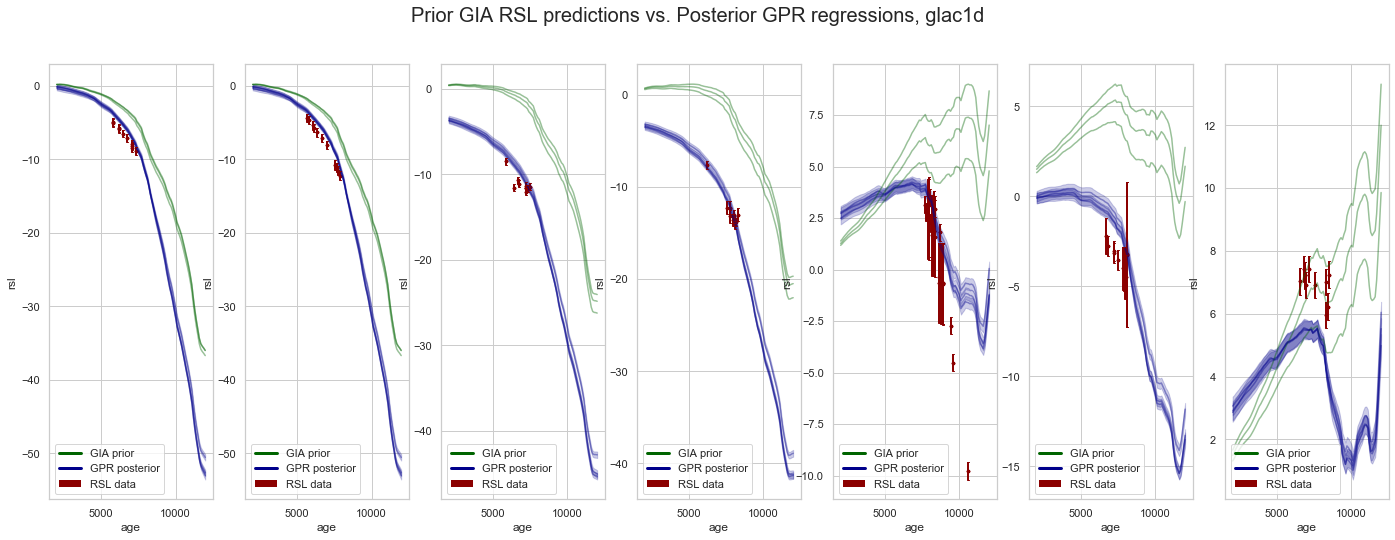

# Now plotted with just the mean and variance of weighted posterior

/anaconda3/envs/gpflow6_0/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


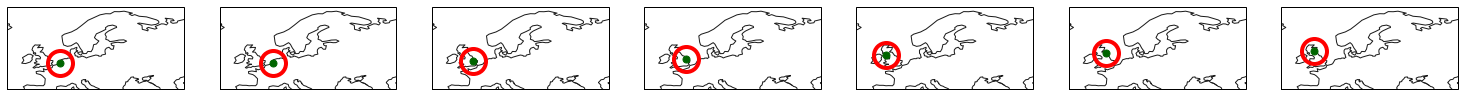

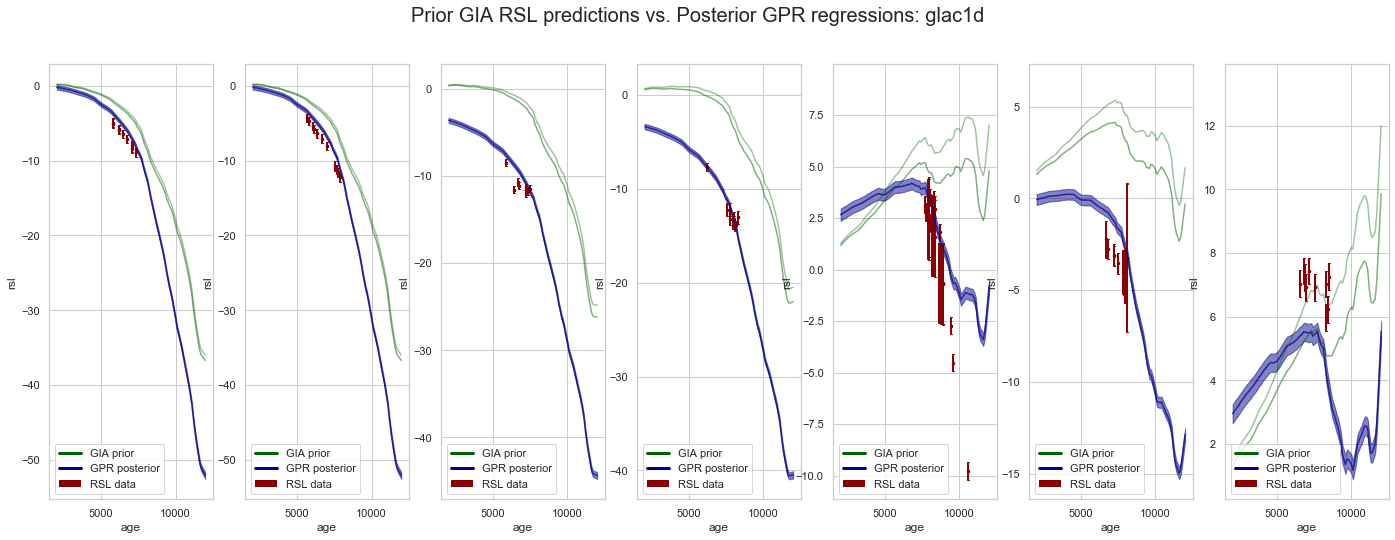

In [25]:
###### Plot Locations #####
proj = ccrs.PlateCarree()

fig, ax = plt.subplots(1,len(nufsamp), figsize=(26, 6), subplot_kw=dict(projection=proj))
ax = ax.ravel()

da_zeros = xr.zeros_like(ds_zp_glac.rsl[0,:,:,:])

for i, site in enumerate(df_nufsamps.groupby('locnum')):
    ax[i].coastlines(color='k')
    ax[i].plot(site[1].lon.unique(), site[1].lat.unique(), c=colormark[0], ms=7, marker='o', transform=proj)
    ax[i].plot(site[1].lon.unique(),site[1].lat.unique(), c=colormark[0], ms=25,marker='o', transform=proj,
                                                                               mfc="None", mec='red', mew=4)
    da_zeros[0].plot(ax=ax[i], cmap='Greys', add_colorbar=False)
#     ax[i].set_title(site[0], fontsize=fontsize)
    ax[i].set_title('')


##### Plot Data-Model fit ######
da_postbig = ds_weightedrsl.rsl.mean(dim='model').load()
colormark = ['darkgreen', 'darkblue', 'darkred', 'violet']


fig, ax = plt.subplots(1, len(nufsamp), figsize=(24, 8))
ax = ax.ravel()

fontsize = 18
lw = 1.5
    
for i, site in enumerate(df_nufsamps.groupby('locnum')):
    
    
    for j, mod in enumerate(df_biglikes.modelrun):
        
        plt.suptitle(f"Prior GIA RSL predictions vs. Posterior GPR regressions: {ice_model[:-1]}", fontsize=20)
        
        weight = df_biglikes[df_biglikes.modelrun == mod].weight[0]

        da_giaprior = ds_priorbig.rsl.sel(model=mod)
        da_varbig = ds_weightedrsl_var.rsl.sel(model=mod)
    

        #slice data for each site
        prior_it = slice_dataarray(da_giaprior)

        post_it = slice_dataarray(da_postbig)
        var_it = slice_dataarray(np.sqrt(da_varbig))
        top = post_it + var_it * 2
        bottom = post_it - var_it * 2

        site_err = 2 * (site[1].rsl_er_max)

        prior_it.plot(ax=ax[i], c=colormark[0], alpha=weight/2, label='GIA prior')# label='Prior $\pm 2 \sigma$') c=cmaps[j]

        post_it.plot(ax=ax[i], lw=lw, c=colormark[1], alpha=weight/2, label='GPR posterior')# label='Posterior $\pm 2 \sigma$') c=cmaps[j],
        ax[i].fill_between(post_it.age, bottom.squeeze(), top.squeeze(), color=colormark[1], alpha=0.2) #  color=cmaps[j],
        ax[i].scatter(site[1].age, site[1].rsl, c=colormark[2], s=3, lw=lw,label='RSL data')
        ax[i].errorbar(site[1].age, site[1].rsl,site_err, c=colormark[2], fmt='none',
                       capsize=1,lw=1.5)

        ax[i].set_title('')

    from matplotlib.lines import Line2D
    from matplotlib.patches import Circle

    lines = [Line2D([0], [0], color=colormark[0], linewidth=3, linestyle='-'), 
             Line2D([0], [0], color=colormark[1], linewidth=3, linestyle='-'),
             Circle([0], 0.1, color=colormark[2], linewidth=3, ec="none")]

    labels = ['GIA prior', 'GPR posterior', 'RSL data']
    ax[i].legend(lines, labels, loc='lower left')


    #         fig.savefig(dirName + f'{path_gen}_1Dfig',
    #                     transparent=True)
plt.show()

In [348]:
def download_files(varname):
    
    globvar = glob.glob(f'output/12000*{varname}')
    lith = ["_".join(val.split('um')[0].split('_')[-2:][:-1]) for val in globvar]
    place = [val.split('_gia')[0].split('_') for val in globvar]
    places = []
    for i, it in enumerate(place):
        [places.append(loc) for loc in it if loc in locs] 
    
    mantle = ["_".join(val.split('C_')[1].split('_')[:2]) for val in globvar]
    model = ["_".join(val.split('_l')[0].split('_')[2:]) for val in globvar]
    ds = xr.open_mfdataset(globvar, concat_dim='mantle', combine='nested')
    ds['mantle'] = mantle

    try:
        ds = ds.rename({'__xarray_dataarray_variable__':'rsl'})
        ds = ds.drop('scale')
#         ds = ds.drop('modelrun')
    except:
        pass
    ds = ds.expand_dims({'lith':lith, 'place':places, 'model':model})
    return ds
names = ['giaprior', 'gp_variance', 'da_zp', 'posterior']
ds_giaprior, ds_var, ds_zp, ds_post  = [download_files(it) for it in names]

In [349]:
ds_zp

<xarray.Dataset>
Dimensions:  (age: 106, lat: 99, lith: 115, lon: 99, mantle: 115, model: 115, place: 115)
Coordinates:
  * lith     (lith) <U4 'l96C' 'l71C' 'l96C' 'l71C' ... 'l96C' 'l96C' 'l96C'
  * place    (place) <U12 'fennoscandia' 'fennoscandia' ... 'fennoscandia'
  * model    (model) <U7 'glac1d' 'glac1d' 'glac1d' ... 'glac1d' 'glac1d'
  * lat      (lat) float64 23.51 24.48 25.46 26.43 ... 70.11 70.26 70.67 71.23
  * age      (age) int64 12000 11900 11800 11700 11600 ... 1800 1700 1600 1500
  * lon      (lon) float64 -86.48 -83.75 -81.03 -78.3 ... 44.38 44.7 45.9 47.11
  * mantle   (mantle) <U9 'ump5_lm9' 'ump5_lm20' ... 'ump2_lm5' 'ump2_lm20'
Data variables:
    rsl      (lith, place, model, mantle, age, lat, lon) float64 dask.array<chunksize=(115, 115, 115, 1, 106, 99, 99), meta=np.ndarray>

In [22]:
test = ds_post.rsl.sel(model='d6g_h6g', place='fennoscandia', lith='l96C').mean(dim=['model', 'place', 'lith']).std(dim=['mantle'])[100]
test = client.persist(test)
test.dask

AttributeError: 'DataArray' object has no attribute 'dask'

In [6]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [18]:
cluster.scale(4)

In [19]:
client

<Client: 'tcp://127.0.0.1:51838' processes=4 threads=8, memory=17.18 GB>

In [364]:
ds_post.sel(model='d6g_h6g').mean(dim='modelrun').plot()



KeyError: 10

In [196]:
ds_giaprior = xr.open_mfdataset(gprior, concat_dim='modelrun', combine='nested')
ds_giaprior

<xarray.Dataset>
Dimensions:   (age: 119, lat: 50, lon: 50, modelrun: 103)
Coordinates:
    scale     (age) float64 dask.array<chunksize=(119,), meta=np.ndarray>
  * lon       (lon) float64 -11.95 -10.74 -9.539 -8.334 ... 44.7 45.9 47.11
  * lat       (lat) float64 43.86 44.42 44.98 45.54 ... 69.55 70.11 70.67 71.23
  * age       (age) int64 200 300 400 500 600 ... 11600 11700 11800 11900 12000
  * modelrun  (modelrun) object 'glac1d_l71C_ump5_lm20' ... 'd6g_h6g_l96C_ump5_lm10'
Data variables:
    rsl       (modelrun, lat, lon, age) float64 dask.array<chunksize=(1, 50, 50, 119), meta=np.ndarray>

In [241]:
places = [val.split('_gia')[0].split('_') for val in gprior][0]
places

['output/12000', '2000', 'glac1d', 'l71C', 'ump5', 'lm20', 'fennoscandia']

In [243]:
var[0]

'output/12000_2000_d6g_h6g_l71C_ump5_lm50_fennoscandia_gp_variance'

In [242]:
places = [val.split('_gia')[0].split('_') for val in var][0]
places

['output/12000',
 '2000',
 'd6g',
 'h6g',
 'l71C',
 'ump5',
 'lm50',
 'fennoscandia',
 'gp',
 'variance']

In [282]:
places = [val.split('_gia')[0].split('_') for val in var]


# print(places[4])
number = 2
if "fennoscandia" in places[number]:
    print('in')
elif "atlantic" in places[number]:
    print('out')
# try:
# except:
#     [s for s in places[number] if "atlantic" in s]


out


[]

In [259]:
places = [val.split('_gia')[0].split('_') for val in var]
try:
    [s for s in places[0] if "fennoscandia" in s]
    [s for s in places[0] if "atlantic" in s]
except:
    pass
# places[0]

In [246]:
def clean(ds, modelrun, runs):
    ds = ds.rename({'__xarray_dataarray_variable__':'var'})
    ds = ds.assign_coords({'modelrun':modelrun, 'run':runs, 'place':places})
    return ds


 
gprior = glob_ds('giaprior')
var = glob_ds('variance')
zp = glob_ds('zp')
post = glob_ds('posterior')


runs = [val.split('/')[1].split('_l')[0] for val in gprior]
places = [val.split('_gia')[0].split('_')[-1] for val in gprior][0]
modelrun = ["_".join(val.split('_f')[0].split('_')[2:]) for val in gprior]

ds_giaprior = xr.open_mfdataset(gprior, concat_dim='modelrun', combine='nested')
ds_giaprior = ds_giaprior.assign_coords({'run':runs, 'place':places}).drop('scale')



runs = [val.split('/')[1].split('_l')[0] for val in var]
places = [val.split('_gia')[0].split('_')[-1] for val in var][0]

modelrun = ["_".join(val.split('_f')[0].split('_')[2:]) for val in var]
ds_var = xr.open_mfdataset(var, concat_dim='modelrun', combine='nested')
ds_var = clean(ds_var, modelrun, runs)
ds_var

# runs = [val.split('/')[1].split('_l')[0] for val in zp]
# modelrun = ["_".join(val.split('_f')[0].split('_')[2:]) for val in zp]
# ds_zp = xr.open_mfdataset(zp, concat_dim='modelrun', combine='nested')
# ds_zp = clean(ds_zp, modelrun, runs)
# ds_zp


# ds_var = ds_var.rename({'__xarray_dataarray_variable__':'var'})
# ds_var = ds_var.assign_coords({'modelrun':modelrun, 'run':runs, 'place':places})
# ds_var

<xarray.Dataset>
Dimensions:   (age: 106, lat: 99, lon: 99, modelrun: 63, run: 63)
Coordinates:
  * lon       (lon) float64 -86.48 -83.75 -81.03 -78.3 ... 44.38 44.7 45.9 47.11
  * lat       (lat) float64 23.51 24.48 25.46 26.43 ... 70.11 70.26 70.67 71.23
  * age       (age) int64 12000 11900 11800 11700 11600 ... 1800 1700 1600 1500
  * modelrun  (modelrun) <U43 'd6g_h6g_l71C_ump2_lm30' ... 'd6g_h6g_l71C_ump3_lm5_atlantic_gp_variance'
  * run       (run) <U18 '12000_1500_d6g_h6g' ... '12000_1500_d6g_h6g'
    place     <U8 'variance'
Data variables:
    var       (modelrun, age, lat, lon) float64 dask.array<chunksize=(1, 106, 99, 99), meta=np.ndarray>

In [154]:
del runs


<xarray.Dataset>
Dimensions:   (age: 119, lat: 50, lon: 50, modelrun: 103, place: 103, run: 103)
Coordinates:
  * lon       (lon) float64 -11.95 -10.74 -9.539 -8.334 ... 44.7 45.9 47.11
  * lat       (lat) float64 43.86 44.42 44.98 45.54 ... 69.55 70.11 70.67 71.23
  * age       (age) int64 200 300 400 500 600 ... 11600 11700 11800 11900 12000
  * modelrun  (modelrun) <U22 'd6g_h6g_l71C_ump4_lm40' ... 'd6g_h6g_l71C_ump4_lm3'
  * run       (run) <U18 '12000_2000_d6g_h6g' ... '12000_2000_d6g_h6g'
  * place     (place) <U12 'fennoscandia' 'fennoscandia' ... 'fennoscandia'
Data variables:
    var       (modelrun, age, lat, lon) float64 dask.array<chunksize=(1, 119, 50, 50), meta=np.ndarray>

In [ ]:
tmax = 12000
tmin = 1500

all_files = glob.glob(f'output/12000*d6g_h6g*atlantic*likelihood')
df = pd.concat((pd.read_csv(f, index_col=None) for f in all_files)) 

df['ice_model'] = [key.split('_l')[0] for key in df.modelrun]
df['lith'] = [key.split('_')[-3:][0] for key in df.modelrun]
df['um'] = [key.split('_')[-3:][1][-1] for key in df.modelrun]
df['lm'] = [key.split('_')[-3:][2][2:] for key in df.modelrun]

df.lm = df.lm.astype(float)
df.um = df.um.astype(float)

heatmap = df.pivot_table(index='um', columns='lm', values='log_marginal_likelihood')

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.heatmap(heatmap,  cmap='coolwarm', ax=ax,  cbar_kws={'label': 'negative log likelihood'})
# ax.set_title(f'{place} {tmax} - {tmin} yrs \n {ice_model} : {df_likes.lith[0]} km lithosphere');